# Intro to Chemical Similarity

Chemical similarity can be defined in several ways, but essentially has the same underlying idea: that chemicals that share certain features (e.g., number of oxygen atoms, total number of rings, etc.) are more 'similar'. 

In order to understand this, we will use the [Fathead Minnow Dataset](https://archive.epa.gov/med/med_archive_03/web/html/fathead_minnow.html) as an example dataset.  We will also use the Python cheminformatics package [rdkit](http://www.rdkit.org/docs/GettingStartedInPython.html). 

In [3]:
from rdkit import Chem 
import pandas as pd

fhmds = pd.read_csv('data/FHMDB.csv')
print("There are {} mols in the fathead minnow dataset".format(len(fhmds)))

There are 753 mols in the fathead minnow dataset


Let's take a look at the database

In [4]:
fhmds.head()

,CODE,NAME,GEOM_MEAN,CAS,MW,LC50,LGP,MLOGP,REMARKS,SMILES,MIXINDEX,TOXINDEX,FATS,BEHAVIOR,LC50RATIO,MOA,MOA_NUM
0,5.0,4-(HEXYLOXY)-M-ANISALDEHYDE,2.67,61096842,263.31,2.67,3.99,NaN,NaN,c1cc(C=O)cc(OC)c1OCCCCCC,0,1.6,NaN,NaN,**,REACTIVE_4,7.4
1,5.0,5-BROMO-2-NITROVANILLIN,73.30,98434345,276.04,73.30,1.88,M,NaN,c1(OC)c(N(=O)=O)c(C=O)cc(Br)c1O,0,3.6,NaN,NaN,1.00*,REACTIVE_4,7.4
2,8.1,DI-N-OCTYLISOPHTHALATE,0.00,4654186,390.56,-99.00,9.76,NaN,NO MORT. AT SAT. 113 UG/L,CCCCCCCCOC(=O)c1cccc(C(=O)OCCCCCCCC)c1,0,0.0,NaN,NaN,NT,EMPTY,0.0
3,3.1,P-CHLOROPHENYL-O-NITROPHENYL ETHER,1.92,39145476,249.65,1.92,4.79,NaN,NaN,c1cc(Cl)ccc1Oc2c(N(=O)=O)cccc2,0,1.4,NaN,TYPE I,2.0,NARCOSIS_I_2,1.2
4,10.4,3'-CHLORO-O-FORMOTOLUIDIDE,46.60,71862027,169.61,46.60,2.27,NaN,NaN,Cc1c(NC=O)cccc1Cl,0,5.0,NaN,NaN,1.02,NARCOSIS_I_3,1.3


The column 'SMILES' contain structural information.  We can create rdkit molecules using this column.

In [5]:
mols = [Chem.MolFromSmiles(smi) for smi in fhmds.SMILES if Chem.MolFromSmiles(smi)]

print("Rdkit created {} mols".format(len(mols)))

Rdkit created 745 mols


Let's draw the first ten..

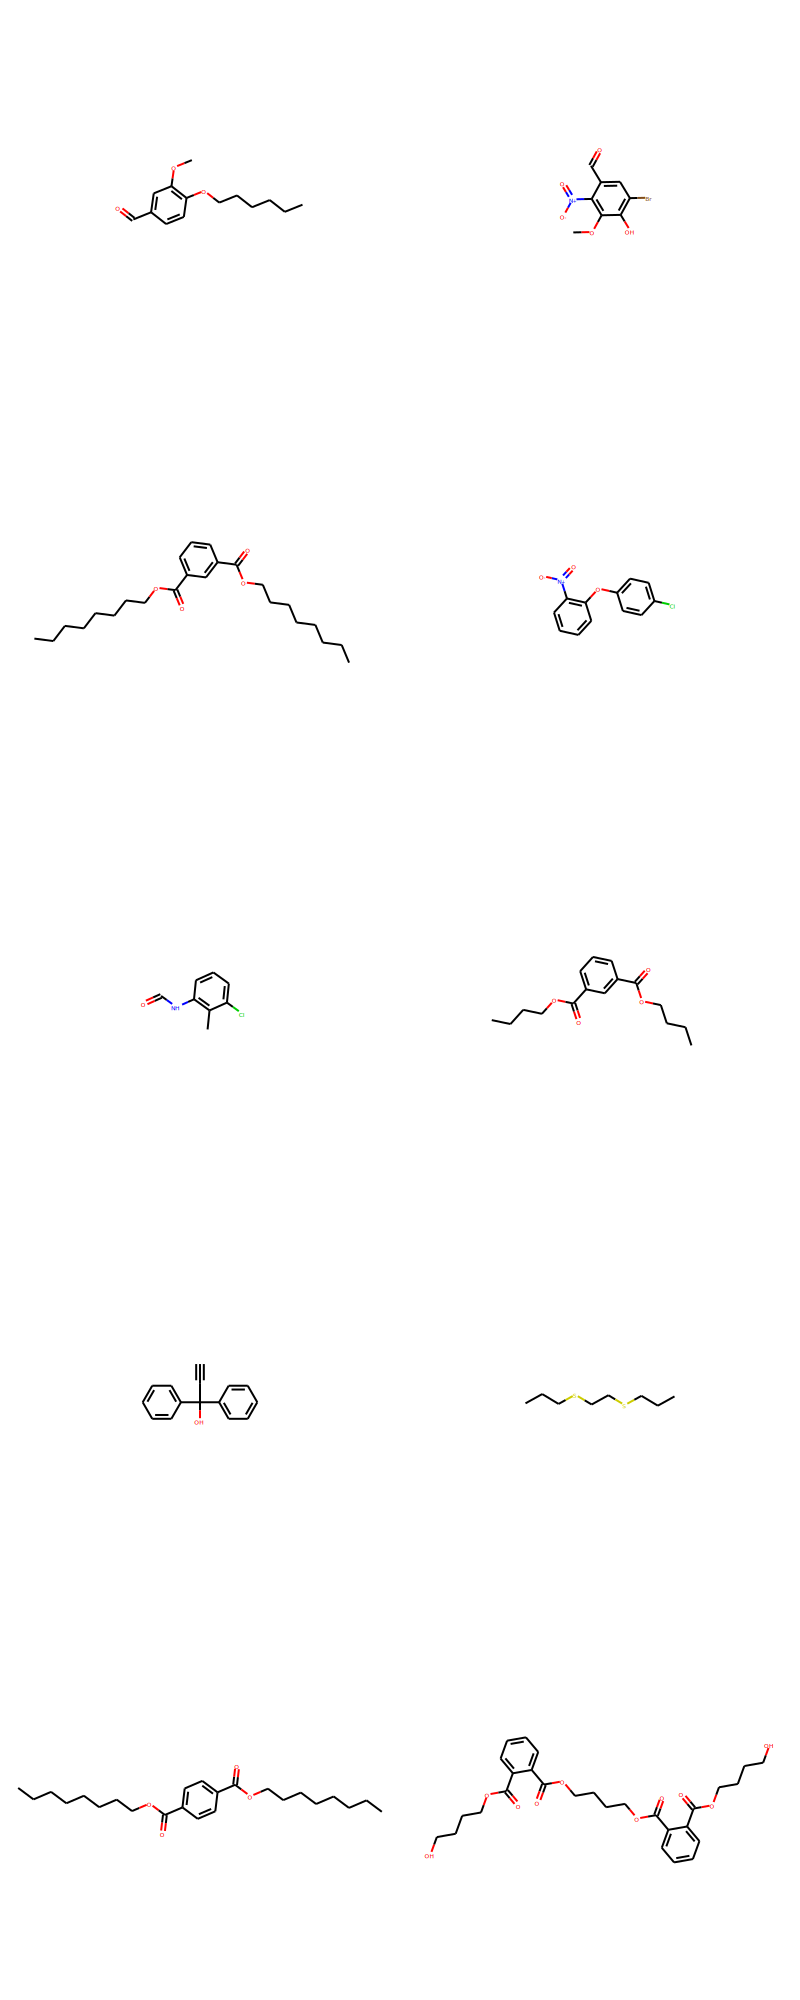

In [6]:
from rdkit.Chem import Draw
from IPython.display import SVG

first_ten = mols[:10]
SVG(Draw._MolsToGridSVG(first_ten, 
                        subImgSize=(400, 400), molsPerRow=2))

The most common way to find chemical similarity is through the use of chemical fingerprints.  A chemical fingerprint is (usually) binary representation of chemical substructures.  There are various types of chemical fingerprints, but for this well use the popular.  Here's some info: http://www.dalkescientific.com/writings/NBN/fingerprints.html

In [7]:
from rdkit.Chem import MACCSkeys

fps = pd.DataFrame([list(MACCSkeys.GenMACCSKeys(mol)) for mol in mols])
fps.head()

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,1,1,1,1,0
1,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,1,1,1,1,0
3,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,1,1,1,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,1,1,1,1,0


In this matrix, we can see that the rows represent an indivual molecules and the columns (0 -> 166) are the fragments, each specifying a unique substructure with a 1 denoting the presence and 0 denoting the absence of a fragment.  The entirity of this would be known as a 'fingerprint'.  

Using these fingerprints, we can calculate the similarity between molecules based on the number of shared features.  The most common measure for this is the Tanimoto coeffiecient, also known as the [Jaccard  index](https://en.wikipedia.org/wiki/Jaccard_index).  Mathematicall it is defined as:

$$J(A,B) = \frac{A \cap B}{A \cup B}$$

Where $A$ and $B$ are fingerprints.  Let's calculate the similarity between every molecule in the dataset using.  We can write code for this ourselves, but its always easier (and sometimes faster) to use code already written.  The machine learning library scikit-learn has many useful functions.  Here we can calculate the jaccard distance, with the Jaccard index just being 1-distance.

In [8]:
from sklearn.metrics.pairwise import pairwise_distances

jac_sim = pd.DataFrame(1 - pairwise_distances(fps, metric="jaccard"))

jac_sim.head()

C:\Users\Daniel\Anaconda3\envs\cheminf\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


,0,1,2,3,4,5,6,7,8,9,...,735,736,737,738,739,740,741,742,743,744
0,1.000000,0.305085,0.657143,0.245614,0.186047,0.571429,0.162162,0.323529,0.657143,0.418605,...,0.666667,0.162791,0.352941,0.121212,0.372093,0.378378,0.348837,0.304348,0.378378,0.216667
1,0.305085,1.000000,0.196721,0.755102,0.320000,0.206897,0.137255,0.016949,0.196721,0.225806,...,0.328125,0.160714,0.033898,0.106383,0.370370,0.245283,0.351852,0.415094,0.346939,0.692308
2,0.657143,0.196721,1.000000,0.135593,0.146341,0.888889,0.147059,0.413793,1.000000,0.540541,...,0.500000,0.179487,0.400000,0.100000,0.250000,0.270270,0.317073,0.191489,0.205128,0.150000
3,0.245614,0.755102,0.135593,1.000000,0.333333,0.142857,0.181818,0.000000,0.135593,0.206897,...,0.316667,0.134615,0.000000,0.069767,0.416667,0.276596,0.367347,0.533333,0.463415,0.744681
4,0.186047,0.320000,0.146341,0.333333,1.000000,0.157895,0.142857,0.030303,0.146341,0.162791,...,0.372093,0.444444,0.029412,0.083333,0.170732,0.176471,0.236842,0.256410,0.379310,0.215686


In [9]:
% matplotlib inline

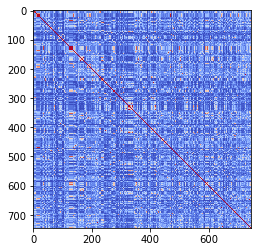

In [11]:
import matplotlib.pyplot as plt

plt.imshow(jac_sim, cmap='coolwarm')
plt.show()

We can see down the diagonal the values are all 1, which makes sense because each chemical should be 100% similar with itself.  Using this matrix we can see how similar molecules are.  Where the max value in each (that's not the same molecule) is what's called the 'chemical nearest neighbor'.  Let's print each molecule with its chemical nearest neighbor.

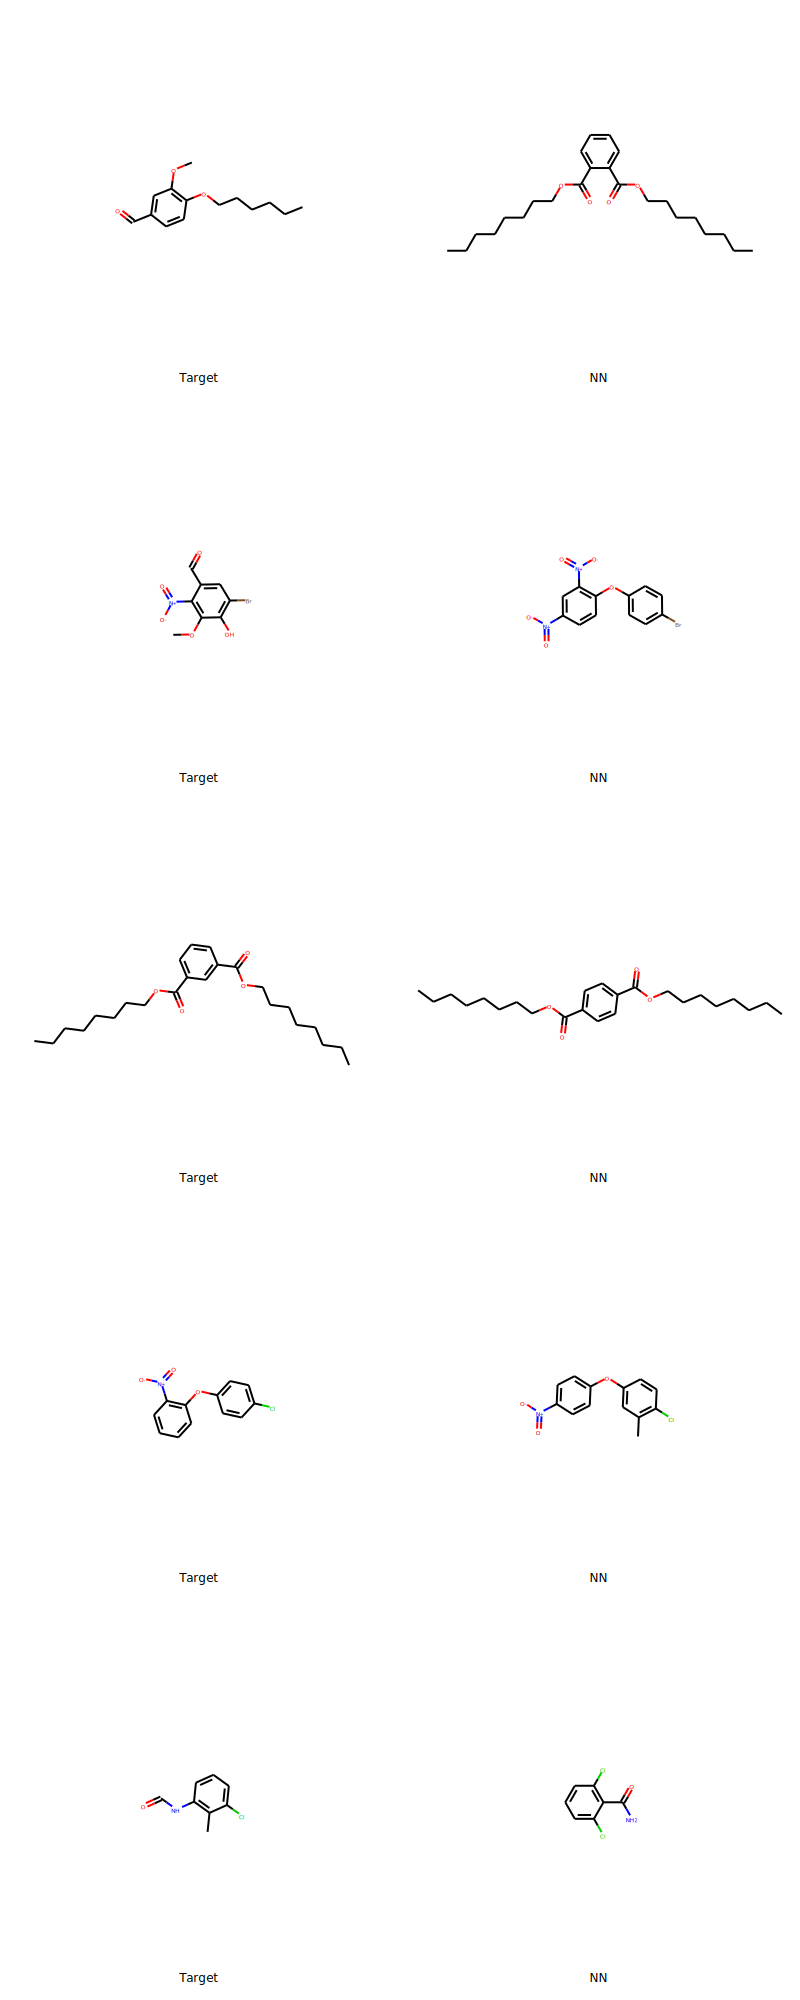

In [17]:
mols_to_image = []
for i, neighbors in jac_sim.iterrows():
    nn = neighbors.drop(i).sort_values(ascending=False).index[0]
    mols_to_image.append(mols[i])
    mols_to_image.append(mols[nn])
legends = ['Target', 'NN'] * 5
SVG(Draw._MolsToGridSVG(mols_to_image[:10], 
                        subImgSize=(400, 400), 
                        molsPerRow=2, legends=legends))